# [IAPR 2019:][iapr2019] Lab 1 ‒  Image segmentation

**Author:** first name and last name  
**Due date:** 04.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
# Import necessary modules
import skimage
import cv2 as cv
import numpy as np
import pandas as pd
from skimage import measure
from collections import Counter

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

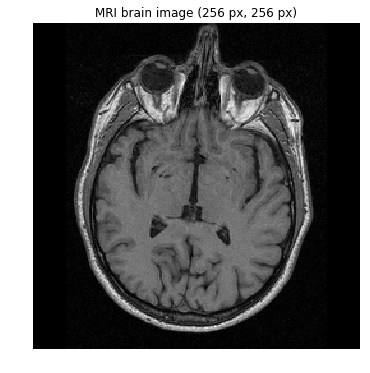

In [5]:
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
Add your implementation and discussion

Text(0.5,1,'Histogram of gray level distribution')

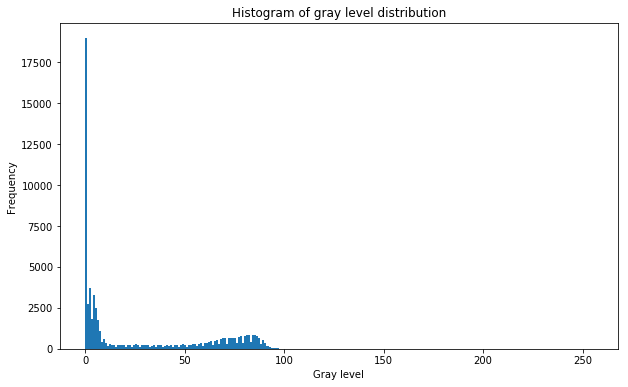

In [162]:
# Explore histogram of image
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
count, bins, _ = ax.hist(brain_im.ravel(), bins = 256, range = (0, 255))
ax.set_xlabel('Gray level')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of gray level distribution')

In [175]:
# Notice that the brain content have gray level around 60 to 100
# By trail and error, we set the thrshold for filtering to be 60 

thrshold = 60

In [165]:
def grow_region(seed, img, thrs):
    """
    Grow region by looking at intensity of eight neighbours
    and compare them to thrs
    Param:  seed (x, y)
            img np.array
            thrs double
    Return: indicator matrix of object containing seed
    """
    
    # Initialize 
    
    # Initialize object image
    obj_img = np.zeros(img.shape)
    obj_img[seed[0], seed[1]] = 1
    
    # Initialize queue for points to check
    deque = [seed]
    
    # Loop to find more obj's points
    while len(deque) > 0:
        
        # Get current point
        current = deque.pop()
        
        # Check eight neighbours
        # Prevent repeat enquing by checking the queue value
        # for a given position first
        x, y = np.meshgrid(np.arange(current[0] - 1, current[0] + 2),
                          np.arange(current[1] - 1, current[1] + 2))
        
        targets = np.column_stack((np.ravel(x), np.ravel(y)))
        
        for target in targets:
            
            # Continue if target already set in obj img or target invalid
            if target[0] < 0 or \
                target[0] > img.shape[0] - 1 or \
                target[1] < 0 or \
                target[1] > img.shape[1] - 1 or \
                obj_img[target[0], target[1]] > 0:
                continue
                
            # Check target's intensity
            obj_img[target[0], target[1]] = img[target[0]][target[1]] > thrs
            
            # Push target into queue if it belongs to obj
            if obj_img[target[0], target[1]] == 1:
                deque.append(target)
    
    return obj_img

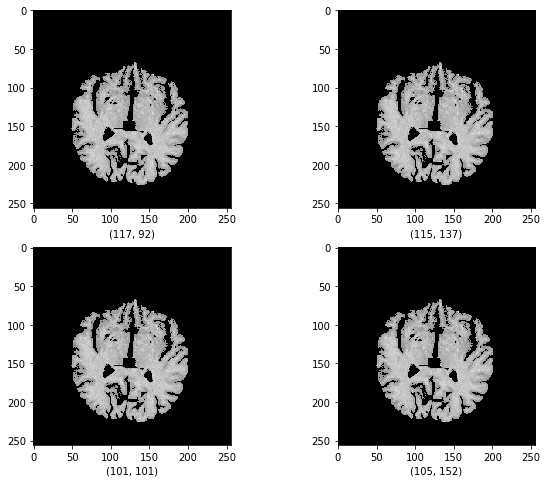

In [184]:
# Randomly select 4 seed inside target region to start, illustrate the result obj
for i in np.arange(4):
    
    x = np.random.randint(low = 80, high = 200)
    y = np.random.randint(low = 80, high = 200)
    mask = grow_region((x, y), brain_im, thrshold)

    # Display the results
    plt.subplot(2, 2, i + 1).imshow(mask * brain_im, cmap = 'gray')
    plt.xlabel((x, y))

Notice that the result is consistent, which indicates the correctness of our expansion algorithm.

In [185]:
# Compute the size of the brain
print('The size of the brain is {0} pixels using region growing'.format(np.sum(mask)))

The size of the brain is 15223.0 pixels using region growing


### 1.3 Contour detection
Add your implementation and discussion

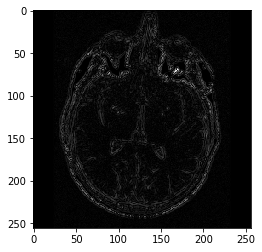

In [138]:
# Play with Laplacian of Gaussian

# Build smoothed img
smooth_img = cv.GaussianBlur(brain_im, (3, 3), 0)

# Calculate Laplacian of Gaussian
abs_dst = cv.convertScaleAbs(cv.Laplacian(smooth_img, cv.CV_16S, 3))

# Visualize edge detected
plt.imshow(abs_dst, cmap = 'gray')

In [139]:
# Convert img to binary by filtering with selected thrshold
filtered_img = brain_im > thrshold

# Convert to unsigned 8 bit int type
filtered_img.astype(np.uint8)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [140]:
# Conduct morphology open operation with 4 * 4 kernel
filtered_img = cv.morphologyEx(filtered_img.astype(np.uint8), cv.MORPH_OPEN,
               np.ones((4, 4), np.uint8))

In [141]:
# Find contour of morphology operation result
filtered_contour, _ = cv.findContours(filtered_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

In [142]:
# Convert filtered img to 3d for visualization
filtered_img = cv.cvtColor(filtered_img, cv.COLOR_GRAY2RGB)

In [144]:
# Show the contour of morphology result
cv.imshow('temp', cv.drawContours(filtered_img, filtered_contour, -1, (0, 255, 0), 3))
cv.waitKey(0)
cv.destroyAllWindows()

Notice that the longest contour should be regarded as the target contour for brain.

In [145]:
# Get the longest contour
longest_contour = sorted(filtered_contour, key = len)[-1]

In [148]:
print('length of longest contour is {0}'.format(len(longest_contour)))

length of longest contour is 762


In [143]:
# Show the longest contour of morphology result
cv.imshow('temp', cv.drawContours(filtered_img, longest, -1, (0, 255, 0), 3))
cv.waitKey(0)
cv.destroyAllWindows()

In the following section we try to use convex hull and polygon to approximate the irregular contour

In [100]:
# Draw convex hull

# Initialize
drawing = np.zeros((256, 256, 3))
color_contours = (0, 255, 0)
color_hull = (255, 0, 0)

# Draw
cv.drawContours(drawing, [longest_contour], -1, color_contours, 3)
cv.drawContours(drawing, [hull], -1, color_hull, 3)
cv.imshow('temp', drawing)

# Clear
cv.waitKey(0)
cv.destroyAllWindows()

In [151]:
# Find approximation polygon

# Initialize
polygon_figure = np.zeros((256, 256, 3))
epi_coef = 0.005
epi = cv.arcLength(filtered_contour[11], True) * epi_coef

# Draw approximation polygon
approx = cv.approxPolyDP(filtered_contour[11], epi, True)
cv.drawContours(polygon_figure, [filtered_contour[11]], -1, color_hull, 2)
cv.drawContours(polygon_figure, [approx], -1, color_contours, 2)
cv.imshow('polygon_approximation', polygon_figure)

# Clear
cv.waitKey(0)
cv.destroyAllWindows()

The approximations convex hull and polygon does not seem to be well fitting.

As a result we directly calculate number of point inside the target contour.

In [121]:
# Get number of point inside or on the contour

# Initialize content matrix
content_matrix = np.zeros((256, 256))

# Set point value to 1 if point resides in contour
for i in np.arange(content_matrix.shape[0]):
    
    for j in np.arange(content_matrix.shape[1]):
        
        content_matrix[j][i] = cv.pointPolygonTest(filtered_contour[11], (i, j), False) >= 0

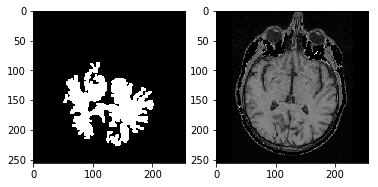

In [124]:
# Display the selected points and original results
plt.subplot(121).imshow(content_matrix * 128, cmap = 'gray')
plt.subplot(122).imshow(brain_im, cmap = 'gray')

In [132]:
print('Size of brain area is ' + str(int(np.sum(content_matrix))) + ' pixels using' + \
        ' contour detection')

Size of brain area is 9535 pixels using contour detection


### 1.4 Additional method(s)
Add your implementation and discussion

## Part 2: Save the bees !

Varroa mites are recognized as the biggest pest to honey bees worldwide, and are believed to be the single largest contributing factor in the modern-day decline of honey bees due to their ability to transmit diseases, resulting in death or severe deformity of the pupae. 

Detecting and quantifying the presence of Verroa in a beehive is therefore crucial to treat the infection appropriately and as early as possible, and image analysis appears very useful in this problem.

![Varroa Mite](https://lts5www.epfl.ch/wp-content/uploads/2018/07/varroa-2.jpg)



### 2.1 Introduction to Project

You will find hereafter a set of 4 images taken under real conditions. In this task you will be ask to:
1. Count the number of Varroa on each picture
2. Determine the Intersection over Union of the detected patterns w.r.t. the ground truth
3. Estimate the Precision, Recall and F1-score at two different IoU thresholds $T = {0.5 \text{, and } 0.9}$


**Note** 

Try to have the same routine(s) running on the four images, and giving (approximatively) the same results. The routine(s) that you will write for this part will be useful for the final project as well, so pay special attention to it.

#### Vocabulary


* **IoU**: Let $A$ be the ground truth area and $B$ the predicted one. the intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$
Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. As a results, we can evaluate the performance of our detection with different values of $T$. The larger $T$ is, the more constraining is our condition.


* **Precision**: The precision is given as:
$$precision = \frac{tp}{tp + fp}$$
where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


* **Recall**: The recall is given as:
$$precision = \frac{tp}{tp + fn}$$
where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


* **F1-score**: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
$$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$


**FAQ**

Q: What to do if I have multiple ground truth $A_i$ and candidates $B_j$ and want to find the best set $(i,j)$ such that $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$ ? 

A: Here, we recommend to use a brute force approach. It corresponds to compute $IoU(A, B)$ for every possible pairs (i,j) and keep the pair with the highest $IoU$. Note that a candidate $B_j$ can **only** be matched to **one** ground truth area $A_i$.

Here, we visualize the 4 images for our patern detection

In [6]:
# Load images
im_names = ['varroa-01', 'varroa-02', 'varroa-03', 'varroa-04']
filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)
print('Number of images: ', len(ic))

Number of images:  4


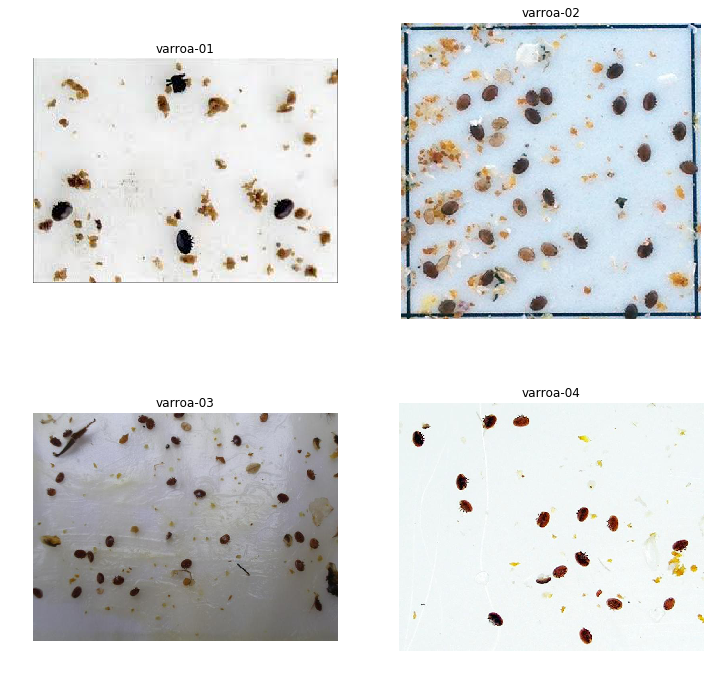

In [7]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), ic, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

We can as well add the groud truth label that are stored in the corresponding XML files. Each xml file stores the position of the varroa on the image as :

```xml
<annotation>
	<object>
		<name>Varroa</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>14</xmin>
			<ymin>117</ymin>
			<xmax>33</xmax>
			<ymax>137</ymax>
		</bndbox>
	</object>
	<object>
		...
	</object>
	...
</annotation>
```
The block `object` defines the attributes of the varroa. `name` is the definition of the object class (always varroa). `bndbox` is the definition of the bounding box. To simplify your task, we implemented a function named `parse_file` that returns an array with the bounding box of the varroa expressed as `(x, y, width, heigth)` which corresponds to `(xmin, ymin, xmax-xmin, ymax-ymin)`

In [8]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [10]:
annotations_xmls = [parse_file(os.path.join(data_path, name) + '.xml') for name in im_names]

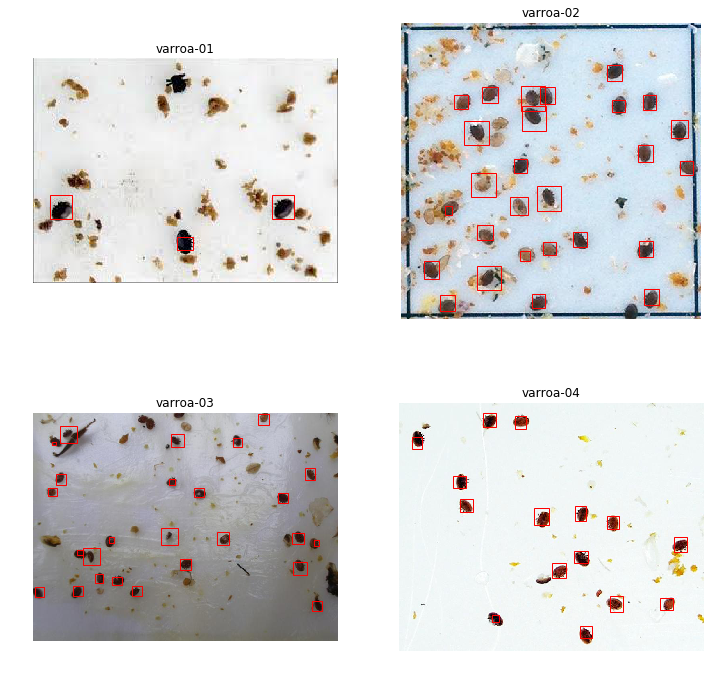

In [11]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Count the number of Varroa on each picture

Add your implementation and discussion

Hint: `skimage.measure.label` might be useful to label the thresholded image

In [12]:
# Convert all imgs to gray
gray_imgs = [skimage.color.rgb2gray(img) * 256 for img in ic]

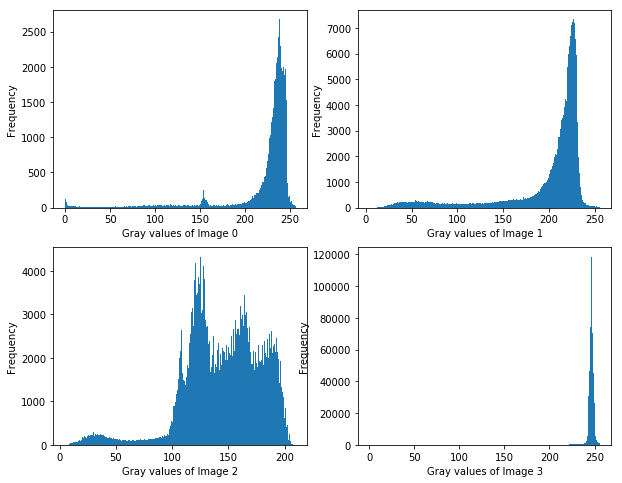

In [13]:
# Explore the histogram of four imgs
fig = plt.figure(figsize = (10, 8))

for i in np.arange(len(gray_imgs)):
    ax = fig.add_subplot(2, 2, i + 1)
    ax.hist(gray_imgs[i].ravel(), bins = 256)
    ax.set_xlabel('Gray values of Image {0}'.format(i))
    ax.set_ylabel('Frequency')

By checking the frequency histogram, we figure out that 90 is a good upper bound to filter out the target objects.

To elaborate our process of finding target objs, we select figure 1 as an example.

In [95]:
# Set forth img as our example
test_id = 2
test_img = gray_imgs[test_id]

# Set thrshold for filtering 
varroa_thrs = 90

In [96]:
# Build mask for test img
mask = (test_img < varroa_thrs)

# Mask test img
masked_test_img = test_img * mask

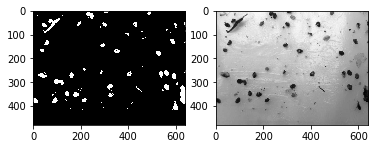

In [97]:
# Compare the mask with test img
plt.subplot(121).imshow(mask, cmap = 'gray')
plt.subplot(122).imshow(test_img, cmap = 'gray')

Notice that there exist some noisy parts in the mask. Furthermore, the sizes of noise tend to be smaller than real obj. This motivates us to filter out noise by setting thrshold on size of obj.

To verify our hypothesis, we illustrate the log distribution of size of obj

In [98]:
# Build label from mask
test_labels = skimage.measure.label(mask)

Text(0.5,1,'Histogram of log size of detected objs')

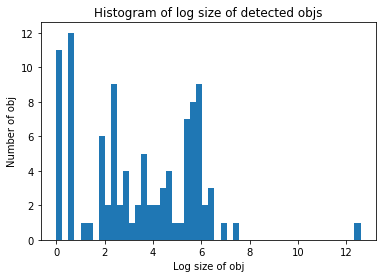

In [99]:
# Check distribution of log size of collections
_ = plt.hist(np.log(np.unique(test_labels, return_counts = True)[1]), bins = 50)
plt.xlabel('Log size of obj')
plt.ylabel('Number of obj')
plt.title('Histogram of log size of detected objs')

Notice that there are many obj with small size, which indicates we are able to filter those noise out by setting an appropriate thrshold on size.

To find a good thrshold, we argue that the histogram of size of obj consists of two distribution, one for noise and the other for real objs.

Then it is natural to set the thrshold to be the mid point of to peaks of two distribution.

In [100]:
# Find size of each labeled obj
index, count = np.unique(test_labels, return_counts = True)

Text(0,0.5,'Count of obj')

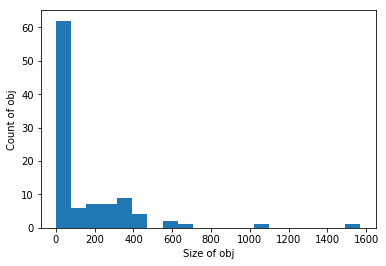

In [101]:
# Illustrate the objs' size distribution
candidate_counts, area_size, _ = plt.hist(count[1 ::], bins = 20)
plt.xlabel('Size of obj')
plt.ylabel('Count of obj')

In [102]:
# Get peaks of two distribution
popular_area_size = area_size[np.argsort(candidate_counts)[:: -1][: 2]]

# Show two peaks' x value
popular_area_size

array([  1. , 314.8])

In [103]:
# Get the thrshold for filtering candidates obj
area_thrshold = np.mean(popular_area_size)

In [104]:
print('The area thrshold for a obj to be valid is {0}'.format(area_thrshold))

The area thrshold for a obj to be valid is 157.9


In [105]:
# Build mask for large obj
index_mask = count > area_thrshold

# Filter out background
index_mask[0] = 0

# Build index mask dict
index_mask_dict = dict(zip(index, index_mask))

Text(0.5,0,'Groundtruth')

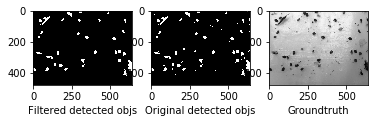

In [106]:
# Illustrate the difference between objs after area filtering and original detected objs
filtered_test_labels = [(x * index_mask_dict.get(x)) > 0 for x in test_labels.ravel()]

filtered_test_labels = np.asarray(filtered_test_labels).reshape(test_img.shape)

# Check filtered result
fig = plt.gcf()
ax = fig.add_subplot(131)
ax.imshow(filtered_test_labels, cmap = 'gray')
ax.set_xlabel('Filtered detected objs')
ax = fig.add_subplot(132)
ax.imshow(test_labels > 0, cmap = 'gray')
ax.set_xlabel('Original detected objs')
ax = fig.add_subplot(133)
ax.imshow(test_img, cmap = 'gray')
ax.set_xlabel('Groundtruth')

Notice that the filtered results have less noise than original results.

In [107]:
# Display the number of obj detected
print('Number of objects detected is {0}'.format(np.sum(index_mask)))

Number of objects detected is 32


### 2.3 IoU of the detected pattern w.r.t. the ground truth

Add your implementation and discussion

Hint: `skimage.measure.regionprops` implements a large variety of descriptors

In [108]:
def display_obj(img_x, img_y, cors):
    """
    Display objs on img
    Params: img_x : int
            img_y : int
            cors : list
    Return: None
    """
    
    # Initialize img
    img = np.zeros((img_x, img_y))
    
    # Fill img with cors
    img[np.asarray(cors)[::, 0], np.asarray(cors)[::, 1]] = 1
    
    # Display the obj
    plt.imshow(img, cmap = 'gray')

In [109]:
def calculate_IoU(a, b):
    """
    Calculate the IoU of a and b
    Params: a: (a.x, a.y, a.w, a.h)
            b: (b.x, b.y, b.w, b.h)
    Return: IoU(a, b)
    """
    
    # Calculate intersection area
    dx = min(a[0] + a[2], b[0] + b[2]) - max(a[0], b[0])
    dy = min(a[1] + a[3], b[1] + b[3]) - max(a[1], b[1])
    
    # Return zero if no intersection
    if dx <= 0 or dy <= 0:
        return 0
    
    # Set intersection area
    int_area = dx * dy
    
    # Calculate union length
    uni_area = a[2] * a[3] + b[2] * b[3] - int_area
    
    return int_area / uni_area 

In [110]:
# Build list of pixel coordinates for each obj
objs = list(map(lambda x: [(i, j) for i in np.arange(test_labels.shape[0])\
                                    for j in np.arange(test_labels.shape[1])\
                                     if test_labels[i][j] == x],
               [k for k in np.arange(len(index_mask)) if index_mask[k] > 0]))

In [111]:
# Build bounding rectangles for objs
# Notice that we need to transpose x and y here
objs_rect = [np.asarray(cv.boundingRect(np.asarray(obj)))[[1, 0, 3, 2]] for obj in objs]

In [112]:
# Build groundtruth coordinates matrix
gt_objs_rect = [annotations_xmls[test_id][i]['bbox'] for i in np.arange(len(annotations_xmls[test_id]))]

In [113]:
# Find optimal IoU for each candidate obj
opt_iou = [np.max([calculate_IoU(x, y) for y in gt_objs_rect]) for x in objs_rect]

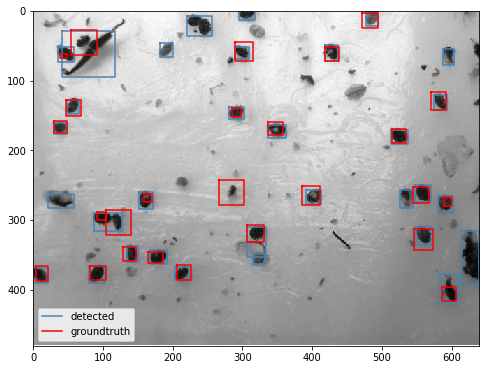

In [114]:
# Visualize the bounding box for ground truth and detected objs
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)
ax.set_xlim(0, test_labels.shape[1])
ax.set_ylim(test_labels.shape[0], 0)

for i, p in enumerate(objs_rect):
    
    if i == 0:
        ax.plot((p[0], p[0], p[0] + p[2], p[0] + p[2], p[0]),
                (p[1], p[1] + p[3], p[1] + p[3], p[1], p[1]),
                c = 'steelblue',
               label = 'detected')
    
    else:
        ax.plot((p[0], p[0], p[0] + p[2], p[0] + p[2], p[0]),
                (p[1], p[1] + p[3], p[1] + p[3], p[1], p[1]),
                c = 'steelblue')
        
for i, p in enumerate(gt_objs_rect):
    
    if i == 0:
        
        ax.plot((p[0], p[0], p[0] + p[2], p[0] + p[2], p[0]),
                (p[1], p[1] + p[3], p[1] + p[3], p[1], p[1]),
                c = 'red',
               label = 'groundtruth') 
        
    else: 
 
        ax.plot((p[0], p[0], p[0] + p[2], p[0] + p[2], p[0]),
                (p[1], p[1] + p[3], p[1] + p[3], p[1], p[1]),
                c = 'red') 
    
ax.legend()
ax.imshow(test_img, cmap = 'gray')


Text(0.5,1,'Histogram of IoU values')

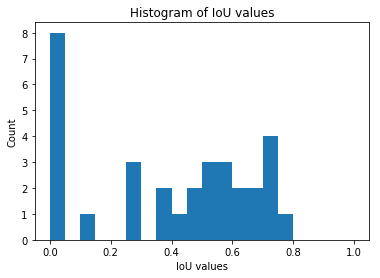

In [115]:
# Display optimal IoU
plt.hist(opt_iou, range = [0, 1], bins = 20)
plt.xlabel('IoU values')
plt.ylabel('Count')
plt.title('Histogram of IoU values')

### 2.4 Precision, Recall and F1-score at two different IoU thresholds

Add your implementation and discussion

In [116]:
# Set IoU thrs to 0.5
iou_thrs = [0.5, 0.9]

In [117]:
# Set metrics to be evaluated
types = ['Accuracy', 'Recall', 'F1-score']

In [118]:
def cal_stats(values, thrs, gt):
    """
    Calculate precision, recall and f1_score for given thrshold
    Param: values : np.array
           thrs : double
           gt : ground truth
    Return: (prec, recall, f1_score)
    """
    
    # Get boolean judgment for values using thrs
    results = np.asarray(values) > thrs
    
    # Get prec
    prec = np.sum(results) / len(values)
    
    # Get rec
    rec = np.sum(results) / len(gt)
    
    # Get f1_score
    f1 = 2 * prec * rec / (prec + rec)
    
    return (prec, rec, f1)

In [119]:
# Calculate statistics for all thrsholds
iou_thrs_stats = dict(zip(iou_thrs, [cal_stats(opt_iou, thrs, gt_objs_rect) for thrs in iou_thrs]))

/home/liangwei/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


In [120]:
# Display the results

# Build iou_thrs_stats as pandas dataframe
iou_thrs_stats_df = pd.DataFrame(iou_thrs_stats, index = ['prec', 'rec', 'f1_score'])

iou_thrs_stats_df

,0.5,0.9
prec,0.468750,0.0
rec,0.576923,0.0
f1_score,0.517241,NaN


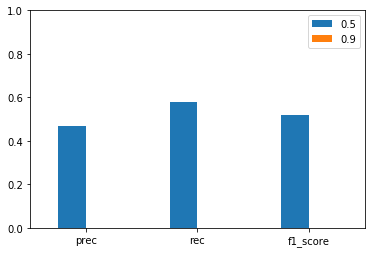

In [121]:
iou_thrs_stats_df.plot(kind = 'bar', rot = 0, ylim = (0, 1))

So far we have elaborated the whole procedure for varroa detection and result evaluation using one img.

We then build functions to enable same process for every img. 

For simplicity we omit figure illustration in the general function.

In [122]:
def detect(img, thrs):
    """
    Detect bounding rectangles of objects in the grayscale img using given thrs
    Param:  img: np.array
            thrs: double
    Return: list of bounding rect
    """
    
    # Build binary img using thrshold
    masked_img = img < thrs
    
    # Find labels for masked img
    labels = skimage.measure.label(masked_img)
    
    # Compute two obj area thrshold 
    index, count = np.unique(labels, return_counts = True)
    
    candidate_counts, area_size, _ = plt.hist(count[1 ::], bins = 20)
    
    area_thrs = np.mean(area_size[np.argsort(candidate_counts)[:: -1][: 2]])

    # Filter out small objs
    index_mask = count > area_thrs
    
    index_mask[0] = 0

    index_mask_dict = dict(zip(index, index_mask))

    filtered_labels = np.asarray([index_mask_dict.get(x) > 0
                                for x in labels.ravel()]).reshape(img.shape)

    # Build bounding rectangle for each obj
    objs = list(map(lambda x: [(i, j) for i in np.arange(labels.shape[0])\
                                    for j in np.arange(labels.shape[1])\
                                     if labels[i][j] == x],
               [k for k in np.arange(len(index_mask)) if index_mask[k] > 0]))
    
    objs_rect = [np.asarray(cv.boundingRect(np.asarray(obj)))[[1, 0, 3, 2]] for obj in objs]
    
    return objs_rect

In [125]:
results_df = pd.DataFrame(index = np.arange(len(gray_imgs)),
                          columns = [columns[0], columns[1]])

/home/liangwei/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


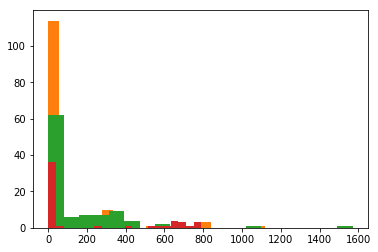

In [129]:
# Display evaluation results for all imgs

# Initialize results dataframe
a, b = np.meshgrid(types, iou_thrs)
columns = np.column_stack((np.column_stack(a).ravel(), np.column_stack(b).ravel())).T

results_df = pd.DataFrame(index = np.arange(len(gray_imgs)),
                          columns = [columns[0], columns[1]])
results_df.index.name = 'Img'

# Loop through all img
for i in np.arange(len(gray_imgs)):
    
    # Get the objs rect
    objs_rect = detect(gray_imgs[i], varroa_thrs)
    
    # Get the ground truth rect
    gt_objs_rect = [annotations_xmls[i][j]['bbox'] for j in np.arange(len(annotations_xmls[i]))]
    
    # Compute evaluation results for all iou_thrs
    stats = [cal_stats([np.max([calculate_IoU(a, b) for b in gt_objs_rect])
                        for a in objs_rect], iou_thrs_instance, gt_objs_rect)
                for iou_thrs_instance in iou_thrs]
    
    results_df.loc[i] = np.column_stack(stats).ravel()

In [130]:
# Illustrate the result
results_df

Accuracy        Recall      F1-score     
          0.5 0.9       0.5 0.9       0.5  0.9
Img                                           
0    0.107143   0         1   0  0.193548  NaN
1    0.294118   0   0.37037   0  0.327869  NaN
2     0.46875   0  0.576923   0  0.517241  NaN
3         0.8   0       0.8   0       0.8  NaN